# Project 1 -- Radiation and SEDs

In this project, we will play with the Planck function and revisit our protoplanetary disk. Q1,2 adapted from Zach Berta-Thompson.

We'll be making use of python functions in the project. Functions are blocks of code that execute when called; they can be defined in a cell in a python notebook (in which case you have to run the cell to define the function) or defined in another file (in which case you have to import them). We can pass variables into a function so that, for example, we can use one function to calculate flux for any temperature blackbody we want.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from astropy import units, constants

plt.matplotlib.rcParams['figure.figsize'] = (10,7)
plt.matplotlib.rcParams['font.size'] = 12
%matplotlib inline

### Q1: 

The Planck function expresses the *intensity* from a thermal emitting source. In terms of wavelength (in a form that can be integrated against $d\lambda$), it can be written as 

$$B_{\lambda}(\lambda, T) = \frac{{2hc}^2}{\lambda^5}\frac{1}{e^{hc/\lambda k_BT} - 1}$$

and has SI units that are equivalent to $J~{s}^{-1}~{m}^{-2}~{sr}^{-1}~{\mu m}^{-1}$. (Note that the  ${\mu m}^{-1}$ in refers to the width of the wavelength range $d\lambda$ -- something you'll see $m$, $nm$, $angstrom$, or other units instead.)

I've defined almost the whole function below, but carefully look through each step and make sure you know what's going on.

+ Fill in the missing line to calculate the flux from intensity

In [2]:
def planck_intensity(wavelength, temperature):
    '''
    This function calculates the intensity of thermal emission
    of a surface.
    '''
    
    # define variables as shortcut to the constants we need
    h = constants.h.cgs
    k = constants.k_B.cgs
    c = constants.c.cgs

    # this is the thing that goes into the exponent (it's units better cancel!)
    u = h*c/(wavelength*k*temperature)    
    
    intensity = (2*h*c**2/wavelength**5/(np.exp(u) - 1))/units.steradian
    return intensity.to('erg/(s*cm**2*micron*steradian)')

def planck_flux(wavelength, temperature):
    '''
    This function calculates the thermal emission spectrum of a surface.
    
        Inputs:
            wavelength = numpy array of wavelengths (in nm)
            temperature = a single number, the temperature (in K)
    
        Outputs:
            Returns an array of thermal emission fluxes,
            in units of erg/(s*cm^2*micron). This is a flux, which has 
            already been integrated over solid angle.
    '''

    # calculate the intensity from the Planck function
    intensity = planck_intensity(wavelength, temperature)

    # calculate the flux, assuming isotropic radiation (as in R&L)
    ## FILL IN THE MISSING LINE OF THE FUNCTION HERE
    flux = np.pi*units.steradian * intensity
    
    # return the flux, in convenient units
    return flux.to('erg/(s*cm**2*micron)')

+ Make a plot of $\lambda$ vs. $F_\lambda(\lambda, T=300~K)$, covering $1-100~\mu m$. Wien's Law states that the peak of this spectrum will be at $\lambda_{\rm max} = b/T$, with $b = 2900~\mu m~K$. (The first two lines have been completed for you)

+ To make sure you have your horizontal axis lined up appropriately, plot a vertical line at this predicted peak location.

In [3]:
# specify a temperature
T = 300*units.K

# create a grid of wavelengths (with units)
w = np.logspace(0, np.log10(100), 1000)*units.micron

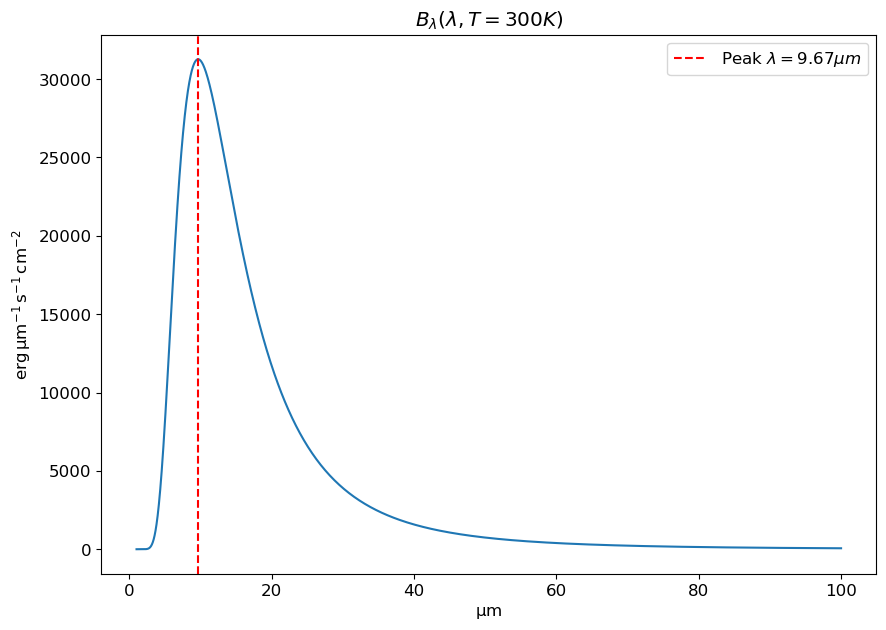

In [4]:
f_lam = planck_flux(w,T);

plt.figure()
plt.plot(w,f_lam)
plt.xlabel(w.unit.to_string('latex_inline'))
plt.ylabel(f_lam.unit.to_string('latex_inline'))
plt.title('$B_\\lambda (\\lambda, T = 300 K)$')
plt.gca().axvline(x=2900/300,color='r',linestyle='--',label=f'Peak $\\lambda = {np.round(2900/300,2)} \\mu m$')
plt.legend(loc='upper right')
plt.show()

+ The Stefan-Boltzmann Law states that the bolometric flux from a surface is
$$F_{\rm bol}(T) = \int^{\infty}_{0}F_{\lambda}(\lambda, T)d\lambda = \sigma_{\rm SB}T^4$$
in units of $erg/cm^2$. To make sure you have the units and overall scale of your Planck function correct, let's make sure we can recover this result. Numerically integrate your Planck function over wavelength, and compare it to the value from this analytic expression. (There are a couple of ways to do this numerical integral; `np.trapz` can integrate along a defined grid of $y$ and $x$, or `scipy.integrate` has tools for directly integrating a function between limits.)

In [5]:
f_bol = np.trapezoid(x=w,y=f_lam) # units of power / area -> this is a flux?
print("Bolometric Flux: ", f_bol)

f_bol_theo = (constants.sigma_sb.cgs * T**4).to(units.erg / units.s / units.cm**2)
print("Theoretical value: ",f_bol_theo)
print("Fractional Error:", np.round(np.abs(f_bol - f_bol_theo)/f_bol_theo * 100,3), "%")

T_sb = ((f_bol / constants.sigma_sb.cgs).decompose())**(1/4)
print("Temperature from S-B Law: ", T_sb)

Bolometric Flux:  457139.11780499114 erg / (s cm2)
Theoretical value:  459300.3279539389 erg / (s cm2)
Fractional Error: 0.471 %
Temperature from S-B Law:  299.6464675626429 K


### Q2: What color is a star?

When we look at a source whose spectrum is $F_\lambda(\lambda)$, our eyes are basically calculating three integrals of that spectrum over wavelength. We perceive different colors as different ratios among these three integrals. Let's write some code to approximate these integrals, so we can display spectra as colors on our computer screens. Flux integrals like these pop up [all the time](https://ui.adsabs.harvard.edu/#abs/2005ARA&A..43..293B/abstract) in astronomy, where we talk about flux through broadband photometric filters.

First, we need to know the effective response of the cones in our eyes to different wavelengths of light. We can approximate these using three "color matching functions" $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, and $\bar{z}(\lambda)$.  The file `ciexyz31.txt` contains a table of these three functions. Load in these color matching functions, and use them to calculate the following three quantities:

$$X = \int F_{\lambda}(\lambda)~\bar{x}(\lambda)~d\lambda $$
$$Y = \int F_{\lambda}(\lambda)~\bar{y}(\lambda)~d\lambda $$
$$Z = \int F_{\lambda}(\lambda)~\bar{z}(\lambda)~d\lambda $$

These are integrals of the intrsinsic spectrum, weighted by the sensitivity of each "filter" to light at each wavelength. You can think of $X$, $Y$, and $Z$ roughly as the brightness of three colored lamps ("pseudo-red", "pseudo-green", "pseudo-blue") which all mix together to form the final color. However, these pseudo-colors aren't exactly the RGB ("red", "green", "blue") colors that our screens display. To get to actual RGB values, these need to be stretched and squeezed a little bit through a linear matrix transformation. The function `xyz2rgb` below handles this conversion for you. 

The final RGB color for a given spectrum should be an array of three numbers, all between 0 and 1. For example, an RGB array of `[0.0, 0.0, 1.0]` means "no brightness in R and G, and full brightness in B", so the color would appear blue. 

In [6]:
def xyz2rgb(X, Y, Z):
    '''
    This function converts CIE XYZ values into CIE RGB values.
    '''

    # normalize these, so they're all between 0 and 1
    x = X/(X+Y+Z)
    y = Y/(X+Y+Z)
    z = Z/(X+Y+Z)

    # make a single column matrix containing the x,y,z values
    xyz = np.matrix([x,y,z]).T
    
    # rgb = conversion * xyz (with matrix math)
    conversion = np.matrix([[0.41847, -0.15866, -0.082835],
                            [-0.091169, 0.25243, 0.015708],
                            [0.00092090, -0.0025498, 0.17860]])
    
    # calculate the rgb single-column matrix
    color_matrix = conversion*xyz

    # 
    color = np.array(color_matrix.T)[0]
    color = color/np.max(color)
    
    return color

+ Make a plot showing the color functions (that is, the "filter response" of your eye) so we can see what we are dealing with.

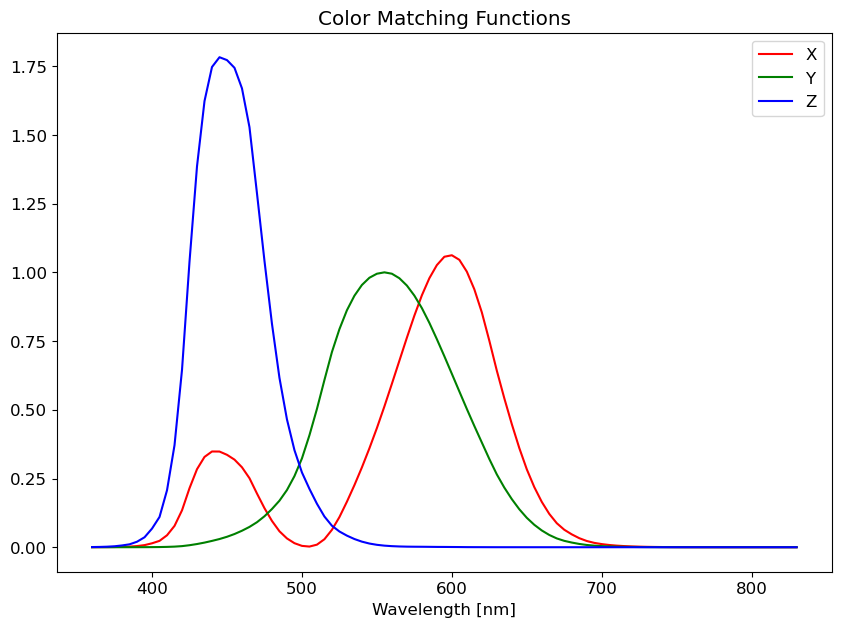

In [20]:
from astropy.io import ascii

ciexyz = ascii.read("ciexyz31.csv")

# rgb = xyz2rgb(ciexyz['X'],ciexyz['Y'],ciexyz['Z'])
plt.figure()
plt.plot(ciexyz['wavelength'],ciexyz['X'],color='r',label='X')
plt.plot(ciexyz['wavelength'],ciexyz['Y'],color='g',label='Y')
plt.plot(ciexyz['wavelength'],ciexyz['Z'],color='b',label='Z')
plt.xlabel('Wavelength [nm]')
plt.title('Color Matching Functions')
plt.legend()
plt.show()

+ Make a plot showing $\lambda$ vs. $F_{\lambda}(\lambda, T)$ for temperatures ranging from $3000~K$ to $10000~K$ in $1000~K$ increments. Take consideration for your axis range and scale choices. In your plot, set the color of each curve to the RGB color you calculate for that spectrum. To do this, write the function temperature2color to get the RGB color for a given temperature. To determine the RGB color, you'll need to 1) calculate the Planck function that corresponds to the given temperature for a wavelength array; 2) integrate the flux over the filter response, that is, compute the X, Y, and Z integrals given in the problem statement; and 3) convert XYZ to python RGB colors using the supplied function.

In [21]:
def temperature2color(T,lam = ciexyz['wavelength'] * units.nanometer):
    '''
    This function takes a temperature (which must have astropy units of K)
    and returns the RGB color of its thermal emission spectrum. 
    '''
    flux = planck_flux(lam,T)
    X = np.trapezoid(flux * ciexyz['X'],x=lam,dx=1.)
    Y = np.trapezoid(flux * ciexyz['Y'],x=lam,dx=1.)
    Z = np.trapezoid(flux * ciexyz['Z'],x=lam,dx=1.)

    color = xyz2rgb(X,Y,Z)
    return color,flux

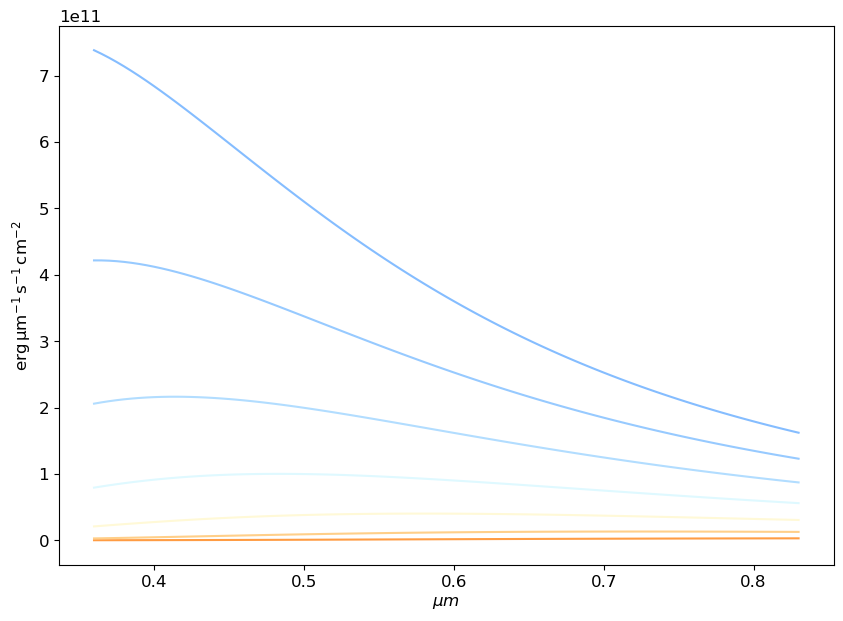

In [26]:
Tarr = np.arange(3e3,1e4,1000) * units.K
# lam = np.linspace(0.1,1,len(ciexyz)) * units.micron

plt.figure()
for temp in Tarr:
    rgb,f = temperature2color(temp)
    plt.plot(ciexyz['wavelength']*units.nanometer.to(units.micrometer),f,color=rgb)
plt.xlabel("$\\mu m$")
plt.ylabel(f.unit.to_string('latex_inline'))
plt.show();

<font color='seagreen'>
Note: there are no green stars! 

### Q3: A protoplanetary disk SED

In HW1, we considered a toy model of a protoplanetary disk: a flat disk that absorbs all the light that hits it and re-radiates that energy as a black body. We derived the temperature profile of the disk:

$$T_{disk} =  T_* {\left(\frac{2}{3\pi}\right)}^{1/4} {\left(\frac{R_*}{r}\right)}^{3/4} $$ 

Now, we'll create a cartoon spectral energy distribution (SED) of a protoplanetary disk. The SED is $\lambda F_\lambda$. In this cartoon, the total wavelength-dependent flux is

$$F_\lambda = F_{\lambda, star} + F_{\lambda, disk}$$

where $F_{\lambda, star}$ is the blackbody of the star and $F_{\lambda, disk}$ is blackbody spectrum of the disk. We calculated $F_{\lambda, star}$ on the first day of class:

$$F_{\lambda, star} = \pi B_\lambda(T_{*})\left(\frac{R_*}{D}\right)^2$$

where $T_{*}$ is the stellar temperature, and $B_\lambda(T_{*})$ is the Planck function (an intensity) at that temperature.

$F_{\lambda, disk}$ is trickier. We have a smooth disk which we will assume to extends from $R_{in}$ to $R_{out}$, where each radius contributes a unique blackbody function. As you'll see in the first homework, we can write:

$$dF_{\lambda, disk}(r) = B_\lambda(T_{disk}(r))\frac{2\pi r}{D^2}\cos{i}dr$$

where $T_{disk}$ is the disk temperature as stated above, $i$ is the inclination of the disk ($i=0$ corresponds to face-on) and $D$ is the distance between the observer and the disk.



In [10]:
def star_sed(wavelength, tstar, rstar, distance):
    '''
    This function takes the properties of the star and returns the SED of 
    the star.
    '''

    star_sed = (np.pi * units.steradian) * wavelength * planck_intensity(wavelength,tstar) * (rstar/distance)**2
    
    return star_sed.to('erg/(s*cm^2)')


def disk_temperature(radius, tstar, rstar):
    '''
    This function takes the properties of the star and returns the disk
    temperature at the given radius.
    '''
    # from hw 1
    tdisk = tstar * (2/(3*np.pi))**(1/4) * (rstar/radius)**(3/4)

    return tdisk

    
def dflux_annulus(wavelength, radius, rstar, tstar, distance, inclination):
    '''
    This function takes a disk radius (which must have astropy units of _ 
    and the constant disk parameters D and i, and returns dFlux: the 
    contribution of this particular annulus of the disk to the total flux.
    The contribution is calculated separately for each inout wavelength.
    '''

    # from the equation in the above markdown - also correcting for solid angle units
    tdisk = disk_temperature(radius,tstar,rstar)
    flux_per_dr = planck_intensity(wavelength,tdisk) * ((2*np.pi*radius)/distance**2) * np.cos(inclination)
    
    return flux_per_dr * (1*units.steradian)

def integrated_disk_sed(wavelength, rstar, tstar, 
                         distance, inclination,
                         r_in=6, r_out=2.3e4):
    
    # an array of radii at which to compute disk fluxes
    radii = np.logspace(np.log10(r_in),np.log10(r_out),1000)*units.R_sun
    
    # empty disk flux at each radius, to fill in
    dflux_array = np.zeros( (len(wavelength),len(radii)) )
    
    # the corresponding radius array
    # this is of shape (100,1000) -> (wavelength.shape, radii.shape)
    # np.tile -> creates an array that contains (wavelength.shape) repeats of the radii array
    # this is used to integrate over radius, giving a resulting array that has shape (wavelength)
    radii_array = np.tile(radii, (len(wavelength),1))

    # need to fill in flux array with the dflux function - for each radius, calc a flux at each wavelength
    for i,rad in enumerate(radii):
        f = dflux_annulus(wavelength,rad,rstar,tstar,distance,inclination)
        dflux_array[:,i] = f

    # units got lost when filling in the array if you did it the way I did
    dflux_array = dflux_array * f.unit
    disk_flux_tot = np.trapezoid(dflux_array, radii_array, axis=1)

    disk_sed = wavelength * disk_flux_tot

    return disk_sed.to('erg/(s*cm^2)') 
    

+ For the parameters below (typical for a young Sun), what is the temperature of the disk at a radius of 10 Rsun?

In [11]:
tstar = 4000*units.K
rstar = 2.5*units.R_sun
radius =  10*units.R_sun
disk_temperature(radius=radius,tstar=tstar,rstar=rstar)

<Quantity 959.85297412 K>

+ For the parameters below, plot the stellar and protoplanetary disk spectra separately, then overplot the combined spectrum. Make sure to label your axes and include a legend.

In [12]:
tstar = 4000*units.K
rstar = 2.5*units.R_sun
distance = 10*units.pc
inclination = 0*units.degree

In [13]:
lam = np.logspace(-0.3,3,100) * units.micrometer
starsed = star_sed(wavelength=lam, tstar=tstar, rstar=rstar, distance=distance)
disksed = integrated_disk_sed(lam, tstar=tstar, rstar=rstar, distance=distance, inclination=inclination)

/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = s

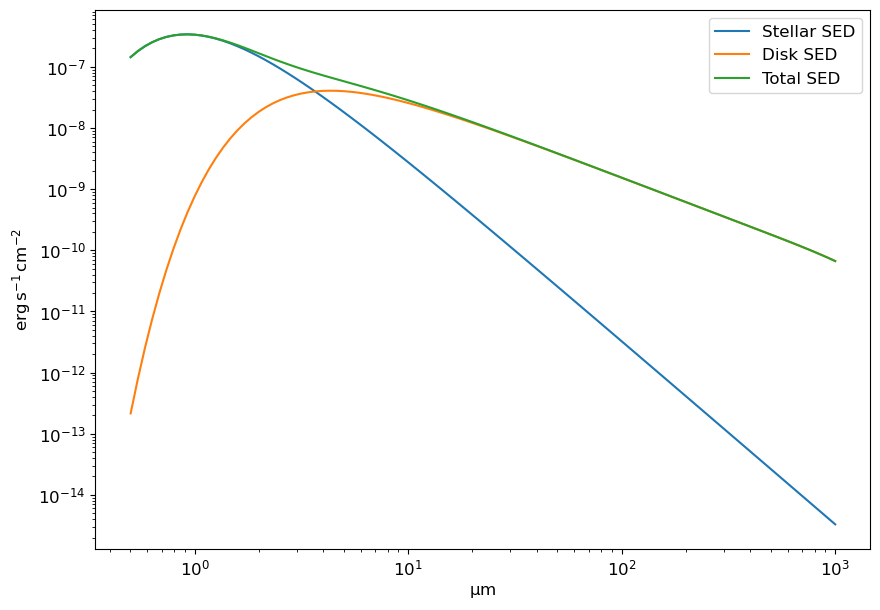

In [14]:
plt.figure()
plt.loglog(lam,starsed,label='Stellar SED')
plt.loglog(lam,disksed,label='Disk SED')
plt.loglog(lam,starsed+disksed,label='Total SED')
plt.legend(loc='upper right')
plt.xlabel(lam.unit.to_string('latex_inline'))
plt.ylabel(starsed.unit.to_string('latex_inline'))
plt.show()

<font color='seagreen'>
We did pretty well! (See, e.g. Figures 6 and 7 here: https://iopscience.iop.org/article/10.1088/0004-637X/700/2/1502#apj308794f6). As it turns out, most disks have stronger slopes to their SED than our model. This can be resolved if a disk is flared. The flared outer disk has a larger surface area and therefore absorbs more flux, which it then emits farther into the infrared.

+ If a disk as a gap in it (like these ones: https://aasnova.org/2018/11/16/the-origin-of-gaps-in-protoplanetary-disks/) what would be the impact on the SED?

A disk with a gap in it would look similar to the plot above, but with a second kink at longer wavelengths. This is because the disk SED is composed of many Planck functions each with a temperature corresponding to the disk temperature at that radius. Removing a set of radii would remove a set of temeratures, which creates another kink in the full SED. 

+ Adapt the code above to simulate the SED of a disk with a gap in it.

In [15]:
def integrated_disk_gap_sed(wavelength, rstar, tstar, 
                         distance, inclination,
                         a=6, b=1e3,
                         c=5e3 ,d=2.3e4):
    ### ASSUME THAT THE TEMP GRADIAENT IS UNAFECCTED BY THE GAP ###
    # basically assuming rings are independant besides temp gradient, just need to call the function twice 
    inner_ring = integrated_disk_sed(wavelength, rstar, tstar, 
                         distance, inclination,
                         r_in=a, r_out=b)
    outer_ring = integrated_disk_sed(wavelength, rstar, tstar, 
                         distance, inclination,
                         r_in=c, r_out=d)

    disk_sed = inner_ring + outer_ring
    return inner_ring.to('erg/(s*cm^2)'), outer_ring.to('erg/(s*cm^2)'), disk_sed.to('erg/(s*cm^2)')

/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/f0080bw/miniconda3/envs/a174/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = s

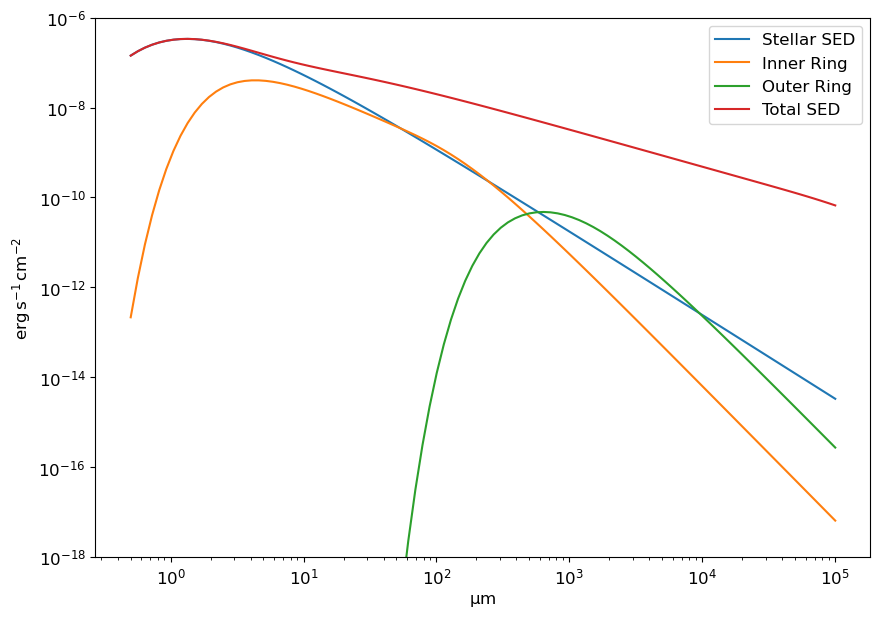

In [16]:
lam = np.logspace(-0.3,5,100) * units.micrometer
starsed2 = star_sed(wavelength=lam, tstar=tstar, rstar=rstar, distance=distance)
inner_ring, outer_ring, disksed2 = integrated_disk_gap_sed(lam, tstar=tstar, rstar=rstar, distance=distance, inclination=inclination)

plt.figure()
plt.loglog(lam,starsed,label='Stellar SED')
plt.loglog(lam,inner_ring,label='Inner Ring')
plt.loglog(lam,outer_ring,label='Outer Ring')
plt.loglog(lam,starsed+disksed,label='Total SED')
plt.legend(loc='upper right')
plt.xlabel(lam.unit.to_string('latex_inline'))
plt.ylabel(starsed.unit.to_string('latex_inline'))
plt.ylim(1e-18,1e-6)
plt.show()